In [1]:
%load_ext autoreload
%autoreload 2

In [115]:
import os

import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.feature_selection import RFECV

from xgboost import XGBRegressor

from owi_data_2_pandas.io import API
# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer
from oma_tracking.data.make_dataset import DatasetGetter
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs




In [3]:
user = os.getenv('API_USERNAME') 
password = os.getenv('API_PASSWORD')
root = r"http://10.0.0.138/api/v1/"
owi = API(api_root=root, username=user, password=password)

In [ ]:
start  = datetime.datetime(2022,10,1,tzinfo=utc)
stop  = datetime.datetime(2023,8,1,tzinfo=utc)

for location in locations[0:1]:
    name_location = '_'.join(['NW2', location.split('nw2')[1].upper()])
    home_folder = "../../"


    ### DATA HANDLING 
    ## Load turbine data
    try:
        # Load data from local source
        print("Loading data from local source")
        data_path = os.path.join(home_folder, "data", "nw2", "raw", location + ".parquet")
        turbine_data = pd.read_parquet(data_path)
    
    except:
        # Load data from API
        print("Loading data from API")
        dsg = DatasetGetter(start, stop, location)
        dsg.get_longterm_data()
        dsg.save_data(data_path)
        turbine_data = dsg.data

    ## Load weather station data
    weather_data_path = "../../data/nw2/mvbc_data.parquet"
    weather_station_data = pd.read_parquet(weather_data_path)

    ## Load the tracked modes   
    modes = ['SS1']
    tracked_modes_data = {}
    for mode in modes:
        mode_data_path = os.path.join(home_folder, "data", "nw2", "tracked_modes", "_".join([mode, location.upper()]) + ".parquet")
        tracked_modes_data[mode] = pd.read_parquet(mode_data_path)


    ### DATA PREPROCESSING

    ## Select the appropriate data frome the turbine data

    # The data is filtered to only include the mean values of the variables
    means_data = turbine_data.filter(regex = 'mean')
    # The data is filtered to remove the ACC data and only keep the SCADA
    means_SCADA_data = means_data.drop(columns = means_data.filter(regex = 'acc|ACC').columns)
    # The cyclic data and angles are transformed to sin and cos
    means_SCADA_data = sin_cos_angle_inputs(means_SCADA_data, angle_type = 'degrees', angles = ['winddirection', 'yaw'])
    # The data is filtered to only include variables with less than 5% missing values
    monitoring_inputs = means_SCADA_data.loc[:, means_SCADA_data.isna().sum() < 0.05 * means_SCADA_data.shape[0]]

    for mode in modes:
        tracked_mode = tracked_modes_data[mode]['frequency'].dropna()
        unique_tracked_mode = tracked_mode.groupby(tracked_mode.index).filter(lambda x: len(x) == 1)
        y = unique_tracked_mode
        X = pd.concat([monitoring_inputs, weather_station_data], axis=1).loc[y.index].dropna()
        y = y.loc[X.index]

        # Split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123)
        X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=123)

    

Loading data from local source


In [126]:
X_train.shape

(16103, 20)

In [ ]:
from catboost import CatBoostRegressor
cb_regr = CatBoostRegressor(iterations=200)
cb_regr.fit(X, y, logging_level='Silent')
feature_statistics = cb_regr.calc_feature_statistics(X,
                            target=y,
                            feature=range(X.shape[1]),
                            plot=True,
                            thread_count=-1,
                            plot_file=None)

In [ ]:
from catboost import CatBoostRegressor
cb_regr = CatBoostRegressor(iterations=200)
cb_regr.fit(X, y, logging_level='Silent')

for i in range(X_train.shape[1]):
    cb_regr.calc_feature_statistics(X,
                            target=y,
                            feature=i,
                            plot=True,
                            thread_count=-1,
                            plot_file=None)

In [160]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

train_pool = Pool(X_train, y_train, feature_names=X_train.columns.tolist())
test_pool = Pool(X_test, y_test, feature_names=X_test.columns.tolist())

model = CatBoostRegressor(iterations=200, random_seed=0)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-19',
    num_features_to_select=1,
    steps=19,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Exact,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [163]:
train_pool = Pool(X_train, y_train, feature_names=X_train.columns.tolist())
test_pool = Pool(X_test, y_test, feature_names=X_test.columns.tolist())

model = CatBoostRegressor(iterations=200, random_seed=0)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-19',
    num_features_to_select=13,
    steps=20,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Exact,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

The number of features selection steps (20) is greater than the number of features to eliminate (7). The number of steps was reduced to 7.


In [165]:
summary

{'selected_features': [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 18],
 'eliminated_features_names': ['mvbc_WandelaarMeasuringpile_Tide_TAW',
  'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
  'mvbc_WandelaarMeasuringpile_Relative_humidity',
  'mvbc_WandelaarMeasuringpile_Average_wind_direction',
  'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
  'mvbc_WandelaarMeasuringpile_Air_temperature',
  'cos_mean_NW2_E01_yaw'],
 'loss_graph': {'main_indices': [0, 1, 2, 3, 4, 5, 6, 7],
  'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7],
  'loss_values': [0.002151457956265057,
   0.002157043260310648,
   0.0021502077125790764,
   0.00215292955646672,
   0.002154706649277082,
   0.0021509268845312465,
   0.002152659045473881,
   0.002156899319915597]},
 'eliminated_features': [16, 15, 17, 14, 13, 19, 5],
 'selected_features_names': ['mean_NW2_E01_rpm',
  'mean_NW2_E01_pitch',
  'mean_NW2_E01_power',
  'mean_NW2_E01_windspeed',
  'sin_mean_NW2_E01_yaw',
  

In [164]:
for i in range(len(X.columns)):
    print(i, X.columns[i])

0 mean_NW2_E01_rpm
1 mean_NW2_E01_pitch
2 mean_NW2_E01_power
3 mean_NW2_E01_windspeed
4 sin_mean_NW2_E01_yaw
5 cos_mean_NW2_E01_yaw
6 sin_mean_NW2_E01_winddirection
7 cos_mean_NW2_E01_winddirection
8 mvbc_WandelaarBuoy_10%_highest_waves
9 mvbc_WandelaarBuoy_Wave_height
10 mvbc_WandelaarBuoy_Average_wave_period
11 mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s
12 mvbc_WandelaarBuoy_Sea_water_temperature
13 mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)
14 mvbc_WandelaarMeasuringpile_Average_wind_direction
15 mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)
16 mvbc_WandelaarMeasuringpile_Tide_TAW
17 mvbc_WandelaarMeasuringpile_Relative_humidity
18 mvbc_WandelaarMeasuringpile_Air_pressure
19 mvbc_WandelaarMeasuringpile_Air_temperature


c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\plots\_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



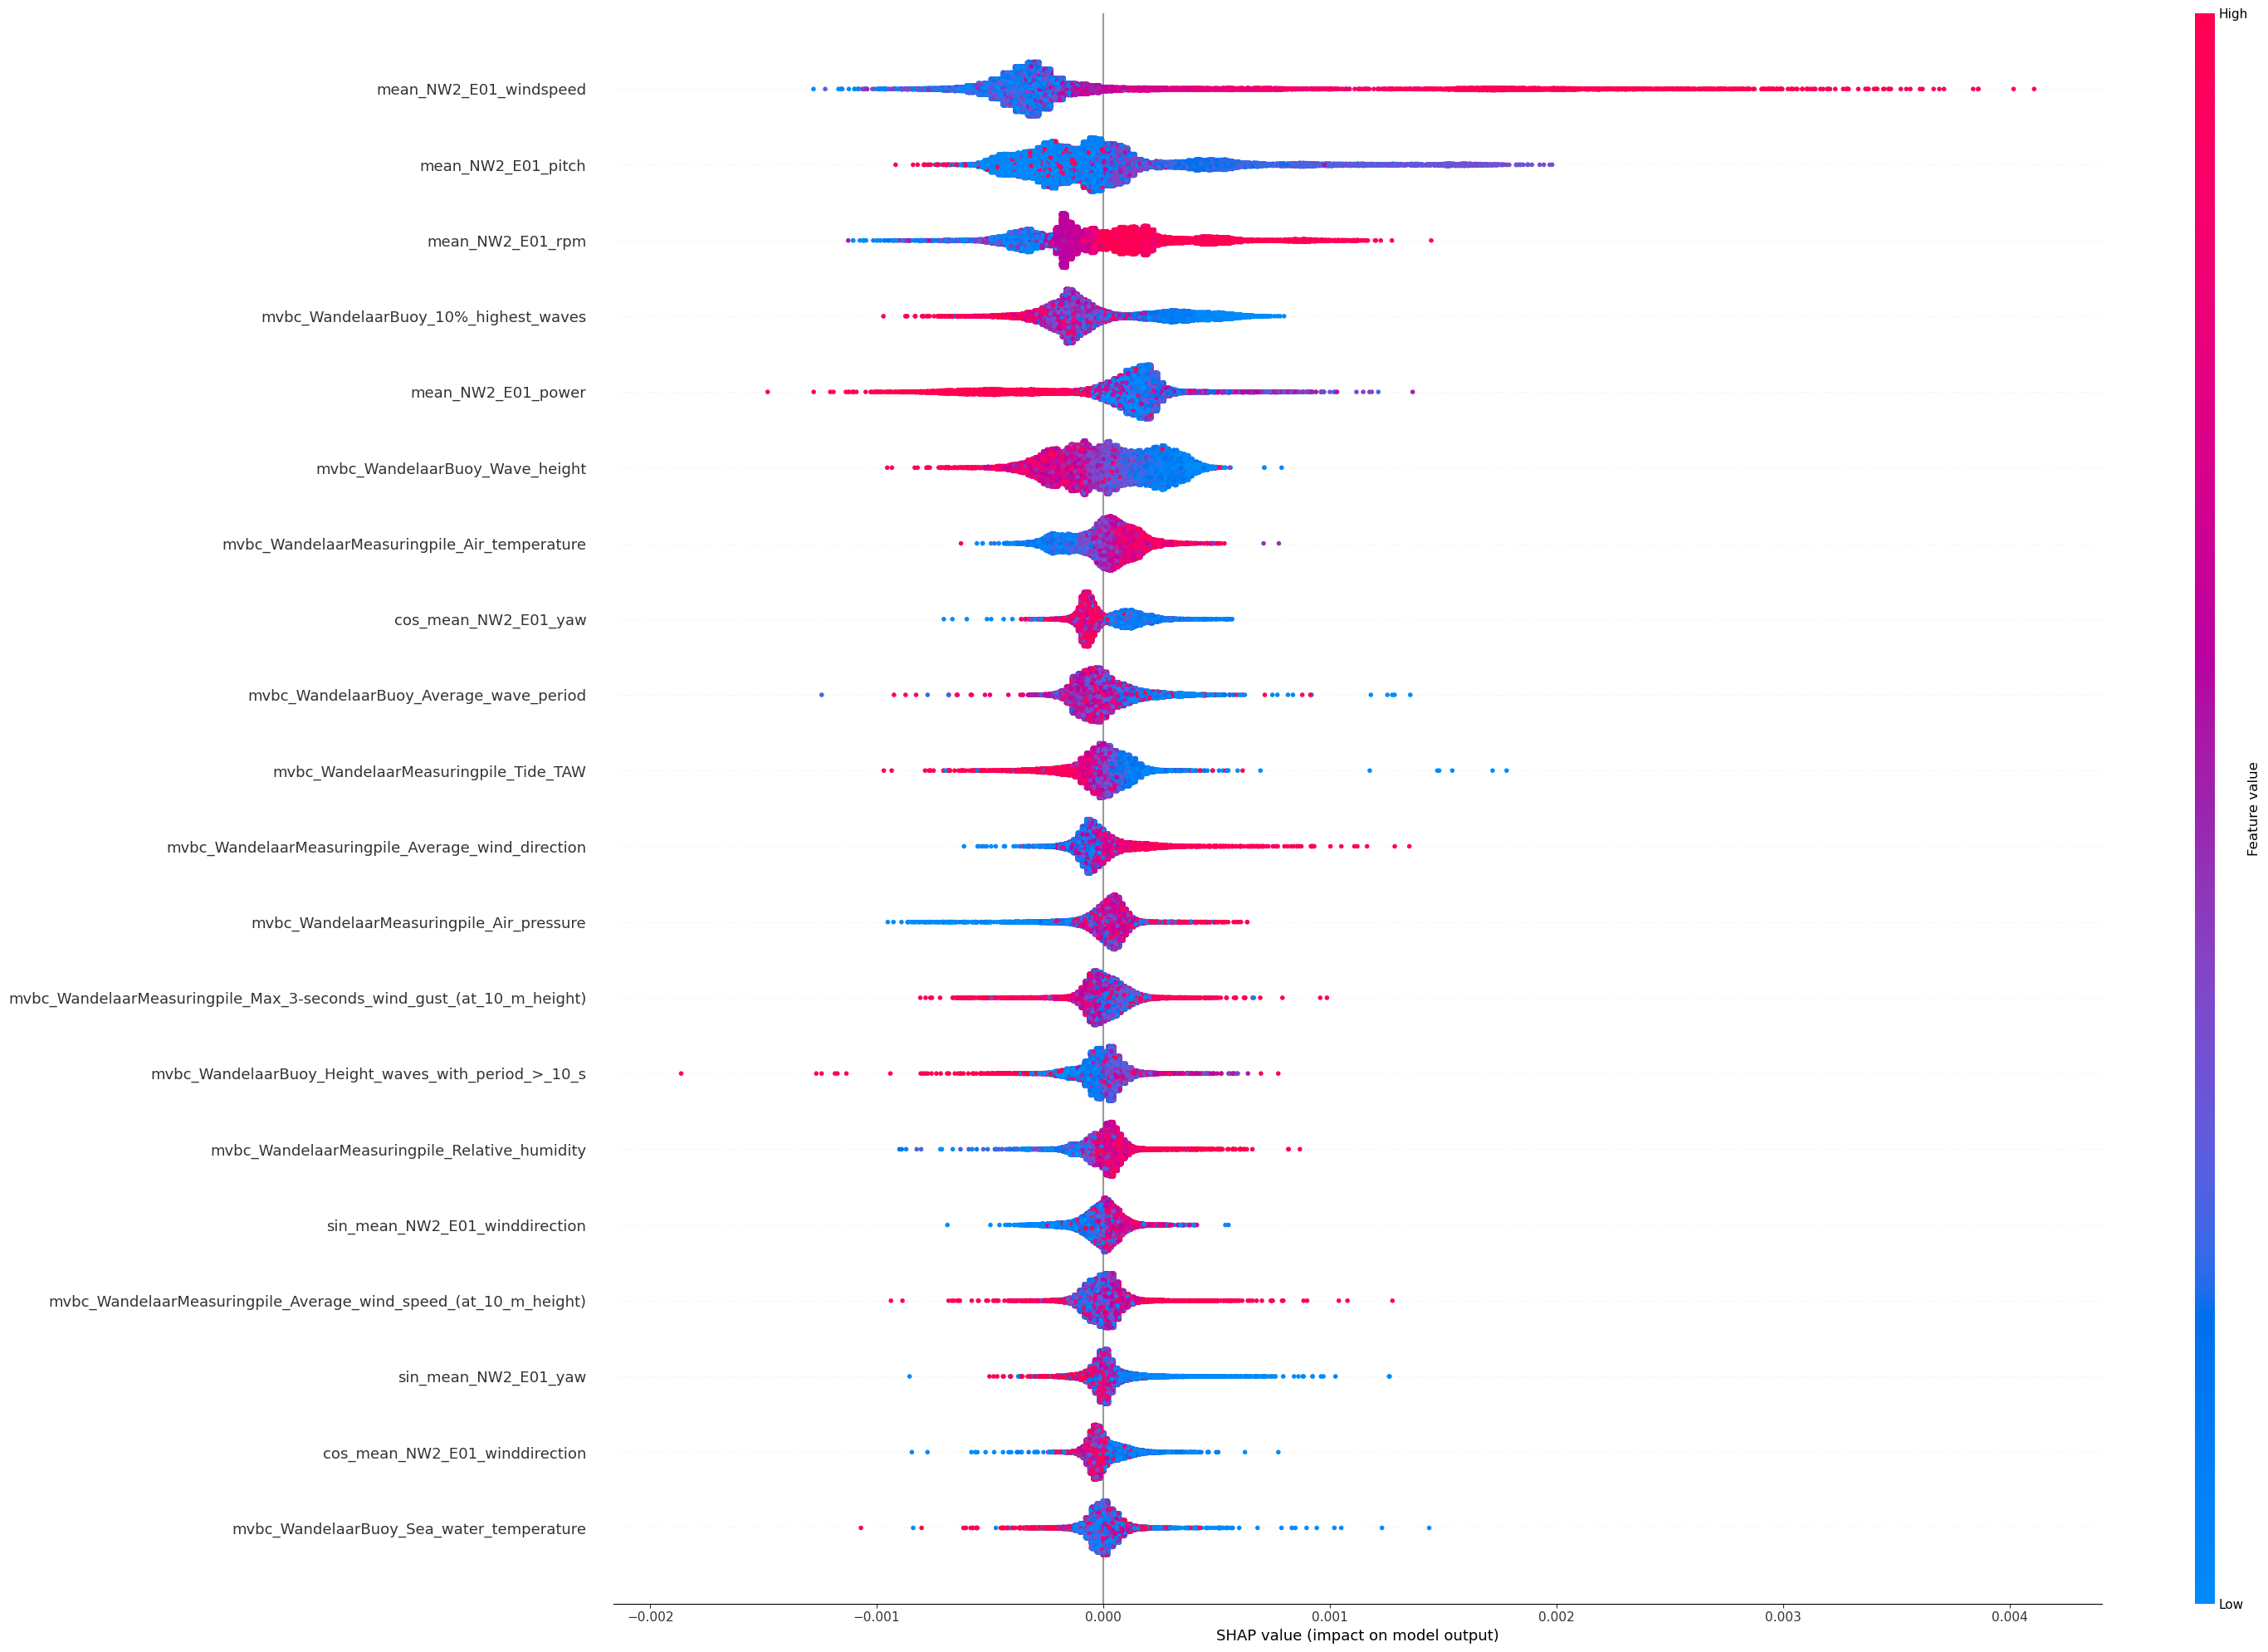

In [153]:
import catboost
from catboost import *
import shap
shap.initjs()

model = CatBoostRegressor(iterations=200, random_seed=0)
model.fit(X, y, verbose=False, plot=False)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_size=[30,20])

In [162]:
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA
from hyperopt import hp
from hyperopt import Trials
import numpy as np
### HYPERPARAM TUNING WITH RANDOM-SEARCH + RECURSIVE FEATURE ELIMINATION (RFE) SHAP ###
regr_xgb = XGBRegressor(early_stopping_rounds=10)

param_dist_hyperopt = {
    'max_depth': 15 + hp.randint('num_leaves', 5), 
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)

}
model = BoostRFE(
    regr_xgb, param_grid=param_dist_hyperopt, min_features_to_select=1, step=1,
    n_iter=X_train_.shape[1], sampling_seed=0, importance_type='shap_importances', train_importance=False
)
model.fit(X_train_, y_train_, trials=Trials(), eval_set=[(X_val, y_val)], verbose=0)


20 trials detected for ('max_depth', 'learning_rate', 'colsample_bytree')



c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\M

trial: 0001 ### iterations: 00099 ### eval_score: 0.01027


c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\M

trial: 0002 ### iterations: 00099 ### eval_score: 0.00228


c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

c:\Users\M

KeyboardInterrupt: 

In [ ]:
print('kept columns', X_train_.columns[model.support_])
print('removed columns', X_train_.columns[~model.support_])

kept columns Index(['mean_NW2_E01_yaw', 'mean_NW2_E01_pitch', 'mean_NW2_E01_power',
       'mean_NW2_E01_towerxacc', 'mean_NW2_E01_toweryacc',
       'mean_NW2_E01_windspeed', 'mean_NW2_E01_NAC_ACC_Z',
       'mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_temperature'],
      dtype='object')
removed columns Index(['mean_NW2_E01_rpm', 'mean_NW2_E01_winddirection',
       'mean_NW2_E01_NAC_ACC_FA', 'mean_NW2_E01_NAC_ACC_SS',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_Wandelaa

In [117]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

train_pool = Pool(X_train, y_train, feature_names=X_train.columns.tolist())
test_pool = Pool(X_test, y_test, feature_names=X_test.columns.tolist())

model = CatBoostRegressor(iterations=1000, random_seed=0)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-22',
    num_features_to_select=10,
    steps=5,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Verbose',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.057263
Step #1 out of 5
0:	learn: 0.0035722	test: 0.0034621	best: 0.0034621 (0)	total: 5.49ms	remaining: 5.48s
1:	learn: 0.0035123	test: 0.0034035	best: 0.0034035 (1)	total: 9.18ms	remaining: 4.58s
2:	learn: 0.0034524	test: 0.0033436	best: 0.0033436 (2)	total: 12.1ms	remaining: 4.04s
3:	learn: 0.0033978	test: 0.0032905	best: 0.0032905 (3)	total: 14.5ms	remaining: 3.61s
4:	learn: 0.0033453	test: 0.0032401	best: 0.0032401 (4)	total: 17.1ms	remaining: 3.4s
5:	learn: 0.0032998	test: 0.0031959	best: 0.0031959 (5)	total: 19.9ms	remaining: 3.3s
6:	learn: 0.0032618	test: 0.0031611	best: 0.0031611 (6)	total: 25.6ms	remaining: 3.63s
7:	learn: 0.0032210	test: 0.0031235	best: 0.0031235 (7)	total: 29.1ms	remaining: 3.6s
8:	learn: 0.0031844	test: 0.0030914	best: 0.0030914 (8)	total: 32.6ms	remaining: 3.58s
9:	learn: 0.0031549	test: 0.0030605	best: 0.0030605 (9)	total: 35.9ms	remaining: 3.55s
10:	learn: 0.0031251	test: 0.0030323	best: 0.0030323 (10)	total: 39.9ms	remaining: 3.5

In [113]:
summary

{'selected_features': [0, 1, 2, 3, 6, 8, 11, 14, 15, 16, 18, 19, 20, 21, 22],
 'eliminated_features_names': ['mean_NW2_E01_towerxacc',
  'mean_NW2_E01_toweryacc',
  'mvbc_WandelaarBuoy_Average_wave_period',
  'mean_NW2_E01_winddirection',
  'mean_NW2_E01_NAC_ACC_FA',
  'mean_NW2_E01_NAC_ACC_SS',
  'mvbc_WandelaarMeasuringpile_Average_wind_direction',
  'mvbc_WandelaarBuoy_Wave_height'],
 'loss_graph': {'main_indices': [0, 8],
  'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7, 8],
  'loss_values': [0.0027789869801651454,
   0.0027769226337208213,
   0.0027755482364099004,
   0.002774340369044819,
   0.002773998152707874,
   0.002773998152707874,
   0.0027739981527078747,
   0.0027754382543967635,
   0.002778037366120813]},
 'eliminated_features': [4, 5, 13, 7, 9, 10, 17, 12],
 'selected_features_names': ['mean_NW2_E01_rpm',
  'mean_NW2_E01_yaw',
  'mean_NW2_E01_pitch',
  'mean_NW2_E01_power',
  'mean_NW2_E01_windspeed',
  'mean_NW2_E01_NAC_ACC_Z',
  'mvbc_WandelaarBuoy_10%_highest_wav

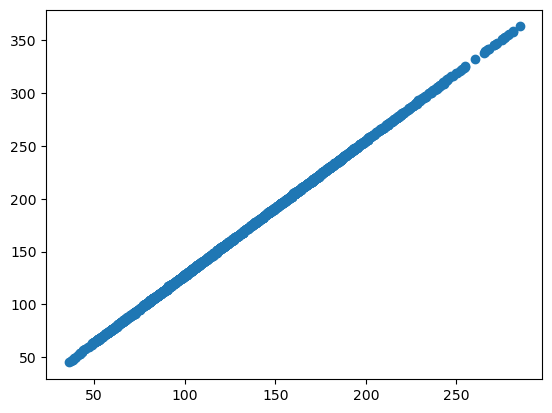

In [90]:
plt.scatter(X['mvbc_WandelaarBuoy_Wave_height'], X['mvbc_WandelaarBuoy_10%_highest_waves'])

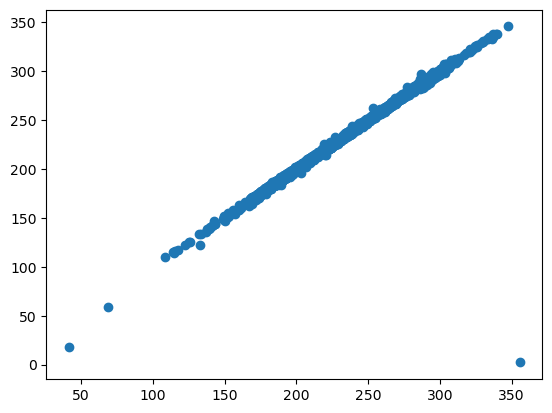

In [91]:
plt.scatter(X['mean_NW2_E01_yaw'], X['mean_NW2_E01_winddirection'])

In [89]:
print('kept columns', X_train_.columns[model.support_])
print('removed columns', X_train_.columns[~model.support_])

kept columns Index(['mean_NW2_E01_yaw', 'mean_NW2_E01_pitch', 'mean_NW2_E01_power',
       'mean_NW2_E01_towerxacc', 'mean_NW2_E01_toweryacc',
       'mean_NW2_E01_windspeed', 'mean_NW2_E01_NAC_ACC_Z',
       'mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_temperature'],
      dtype='object')
removed columns Index(['mean_NW2_E01_rpm', 'mean_NW2_E01_winddirection',
       'mean_NW2_E01_NAC_ACC_FA', 'mean_NW2_E01_NAC_ACC_SS',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_Wandelaa

In [83]:
### RECURSIVE FEATURE ELIMINATION (RFE) SHAP ###
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA
regr_xgb = XGBRegressor()
model = BoostRFE(
    regr_xgb, min_features_to_select=1, step=1,
    importance_type='shap_importances', train_importance=True
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0)
print('kept columns', X_train_.columns[model.support_])
print('removed columns', X_train_.columns[~model.support_])

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

kept columns Index(['mean_NW2_E01_rpm', 'mean_NW2_E01_yaw', 'mean_NW2_E01_pitch',
       'mean_NW2_E01_power', 'mean_NW2_E01_towerxacc',
       'mean_NW2_E01_toweryacc', 'mean_NW2_E01_windspeed',
       'mean_NW2_E01_winddirection', 'mean_NW2_E01_NAC_ACC_Z',
       'mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasuringpile_Air_temperature'],
      dtype='object')
removed columns Index(['mean_NW2_E01_NAC_ACC_FA', 'mean_NW2_E01_NAC_ACC_SS',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_Wandelaa

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [78]:
### RECURSIVE FEATURE ELIMINATION (RFE) SHAP ###
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA
regr_xgb = XGBRegressor()
model = BoostRFE(
    regr_xgb, min_features_to_select=1, step=1,
    importance_type='shap_importances', train_importance=False
)
model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=6, verbose=0)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

BoostRFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                gamma=None, gpu_id=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None,
                                learning_rate=None, max_bin=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                                max_depth=None, max_leaves=None,
                                min_child_weight=None, missing=nan,
                                monotone_constraints=None, n_estimators=100,
                                n_jobs=None, num_parallel_tree=None,
                                predictor=None, random_state=None,
                                reg_alpha=None, reg_lambda=None, ...),
         importance_type='shap_importances', min_features_to_select=1,
         train_importance=False)

In [81]:
model.estimator_, model.n_features_

(XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
              reg_lambda=1, ...),
 8)

In [82]:
print('kept columns', X_train_.columns[model.support_])
print('removed columns', X_train_.columns[~model.support_])

kept columns Index(['mean_NW2_E01_yaw', 'mean_NW2_E01_pitch', 'mean_NW2_E01_power',
       'mean_NW2_E01_windspeed', 'mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_temperature'],
      dtype='object')
removed columns Index(['mean_NW2_E01_rpm', 'mean_NW2_E01_towerxacc', 'mean_NW2_E01_toweryacc',
       'mean_NW2_E01_winddirection', 'mean_NW2_E01_NAC_ACC_Z',
       'mean_NW2_E01_NAC_ACC_FA', 'mean_NW2_E01_NAC_ACC_SS',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasur

In [73]:
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV

xgb_regr = XGBRegressor()
rfecv = RFECV(estimator=xgb_regr, step=1, cv=5, scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             gamma=None, gpu_id=None, grow_policy=None,
                             importance_type=None, interaction_constraints=None,
                             learning_rate=None, max_bin=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=None, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=None, num_parallel_tree=None,
                             predictor=None, random_state=None, reg_alpha=None,
                             reg_lambda=None, ...),
      scoring='neg_mean_squared_error')

In [75]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 1


In [74]:
rfecv.transform(X_train)

array([[10.082],
       [13.684],
       [ 5.246],
       ...,
       [12.449],
       [13.844],
       [19.656]])

In [70]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 1


In [ ]:
name_location = 'NW2_C02'

dsg = DatasetGetter(start, stop, location)
dsg.get_longterm_data()
dsg.data

In [4]:
start  = datetime.datetime(2022,10,1,tzinfo=utc)
stop  = datetime.datetime(2023,7,4,tzinfo=utc)
locations = owi.groups.iloc[4]['locations']
for location in locations:


['nw2e01',
 'nw2f01',
 'nw2d01',
 'nw2a01',
 'nw2a02',
 'nw2a03',
 'nw2a04',
 'nw2b01',
 'nw2b02',
 'nw2b03',
 'nw2c02',
 'nw2c03',
 'nw2c04',
 'nw2d02',
 'nw2d03',
 'nw2d04',
 'nw2e02',
 'nw2e03',
 'nw2e04',
 'nw2f02',
 'nw2f03',
 'nw2f04',
 'nw2c01']

In [ ]:
start  = datetime.datetime(2022,10,1,tzinfo=utc)
stop  = datetime.datetime(2023,7,4,tzinfo=utc)

location = 'nw2c02'
name_location = 'NW2_C02'

dsg = DatasetGetter(start, stop, location)
dsg.get_longterm_data()